In [1]:
import Pkg; Pkg.activate(".")

  Activating project at `/mnt/chromeos/GoogleDrive/Computers/Il mio iMac/Programmi/julia/PValue.jl/docs`


In [8]:
using CairoMakie
using DataFrames
using Format
using PValue
using PairPlots
import StatsPlots
using Turing

## Data

First, we generate a set of plausibile data to be fit by a striaght line.

In [9]:
data = Array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39,
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])
x, y, ey = data;

Let's plot them:

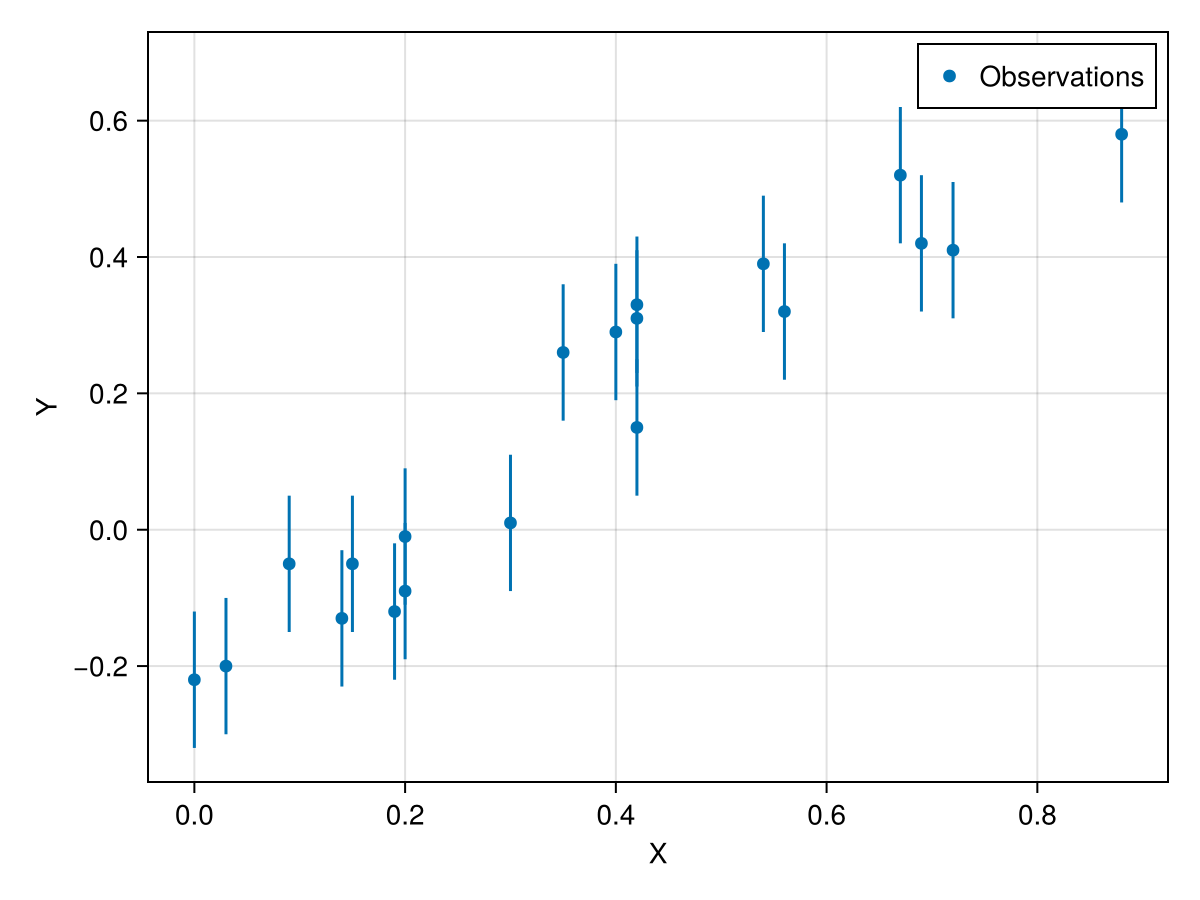

In [10]:
f = Figure()
ax = Axis(f[1, 1],
    xlabel = "X",
    ylabel = "Y"
    )
scatter!(x,y,label="Observations")
errorbars!(x,y,ey)
axislegend(ax)
f

Let's define now a (probabilistic) model to fit our data. Detailes can be found elsewhere (e.g., the [Turing](https://turing.ml/) documentation). Yet, please note how we changed the input variable of the model to make priors easier to write.

In [11]:
# Declare our Turing model
@model function jmodel(x,ey,y)
    # Our prior belief
    theta ~ Uniform(-0.5 * π, 0.5 * π)
    q_perp ~ Normal(0.,5.)
    #
    m = tan.(theta)
    q = q_perp./cos.(theta)
    #
    #for i in 1:length(y)
    #    y[i] ~ Normal.(m*x .+ q,ey)
    #end
    return y ~ MvNormal(m*x .+ q,ey)
end

jmodel (generic function with 2 methods)

Independently of the probabilistic model we can solve the problem finding the best-fit values with a plain MLE analysis.

In [12]:
mle_estimate = maximum_likelihood(jmodel(x,ey,y))

ModeResult with maximized lp of 22.01
[0.7727521086070754, -0.14555816389265744]

Abd, a usual, a p-value can be derived comparing the residuals of the best-fit with expectations from the $\chi^2$ distribution.

In [13]:
theta_fit = mle_estimate.values[1]
q_perp_fit = mle_estimate.values[2]
m_fit = tan(theta_fit)
q_fit = q_perp_fit/cos(theta_fit)
printfmtln("m_fit = {1:.4f}, q_fit={2:.4f}",m_fit, q_fit)
#
fl = x.*m_fit .+ q_fit
ssrv = SSR(fl,y,ey)
printfmtln("Frequentist p-value: {:.4f}", Frequentist_p_value(ssrv,length(x),2))

m_fit = 0.9750, q_fit=-0.2033
Frequentist p-value: 0.8801


The obtained p-value shows our fit is fine and we cannot reject the null hypotesis.

However, a frequentst analysis aims at deriving a point estimate, i.e. just the best-fit values, we now carry out a Baysesian analysis computing the full posterior distribution for the parameters.

In [14]:
iterations = 2000
chains = 4

# Start sampling.
#chain = sample(jmodel(x,ey,y), NUTS(), MCMCThreads(), iterations, chains)
chain = mapreduce(c -> sample(jmodel(x,ey,y), NUTS(), iterations), chainscat, 1:chains)


┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
└   ϵ = 0.0015625
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (2000×14×4 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 4
Samples per chain = 2000
Wall duration     = 13.08 seconds
Compute duration  = 9.75 seconds
parameters        = theta, q_perp
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       theta    0.7622    0.0489    0.0010   2679.3206   3492.3946    1.0012   ⋯
      q_perp   -0.1414    0.0244    0.0005   2627.6284   3529.3281    1.0005   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 



Diagnostics indicate the chains have converged to a stationary distribution. Let's also see the results visually.

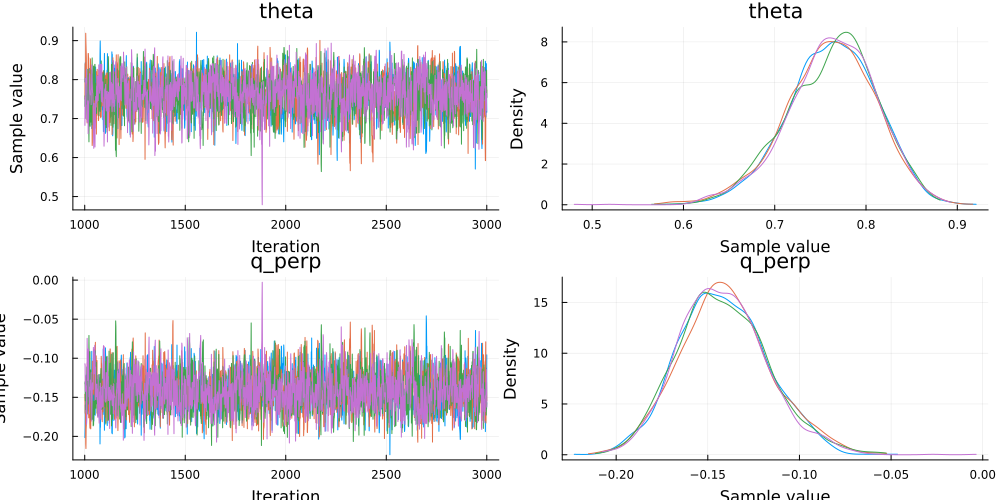

In [15]:
StatsPlots.plot(chain)

A "classic" corner plot can also be very expressive:

In [16]:
dfc = DataFrame(chain);

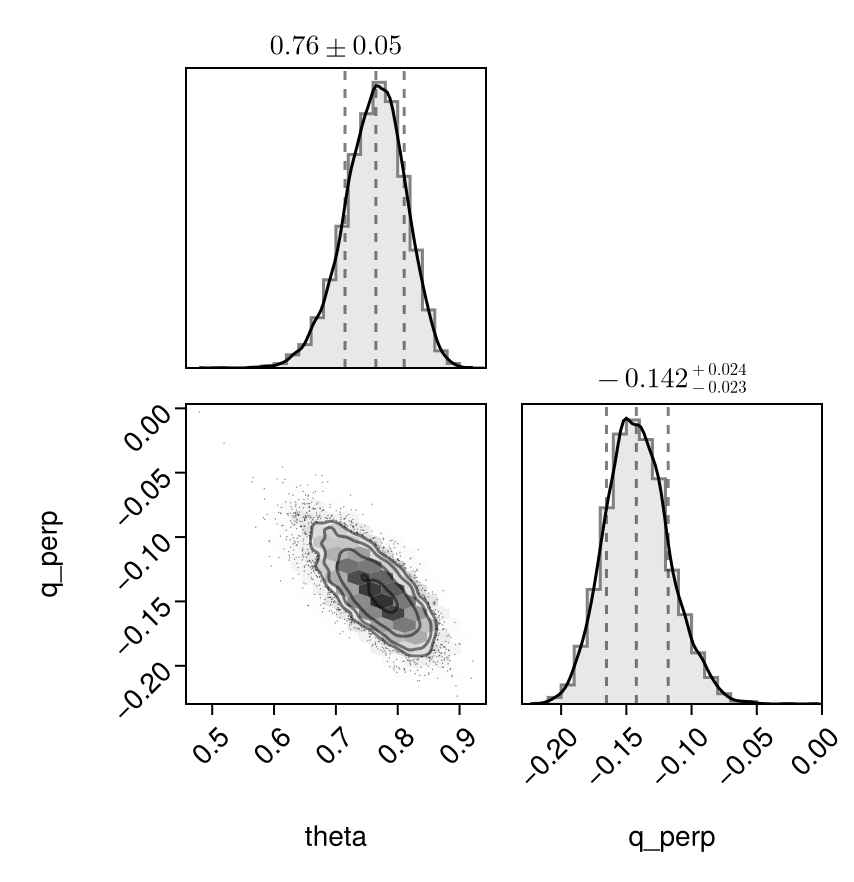

In [17]:
dfcs = select(dfc, [:theta,:q_perp])
pairplot(dfcs)

And we see posteriors are single-peaked, reasonably close to a Gaussian shape, and their modal values gracely agreee with the MLE analysis results (not a general rule, though).

Let's plot some of the posterior entries:

In [18]:
q_bay = chain[:,:q_perp,:]./cos.(chain[:,:theta,:])
m_bay = tan.(chain[:,:theta,:]);

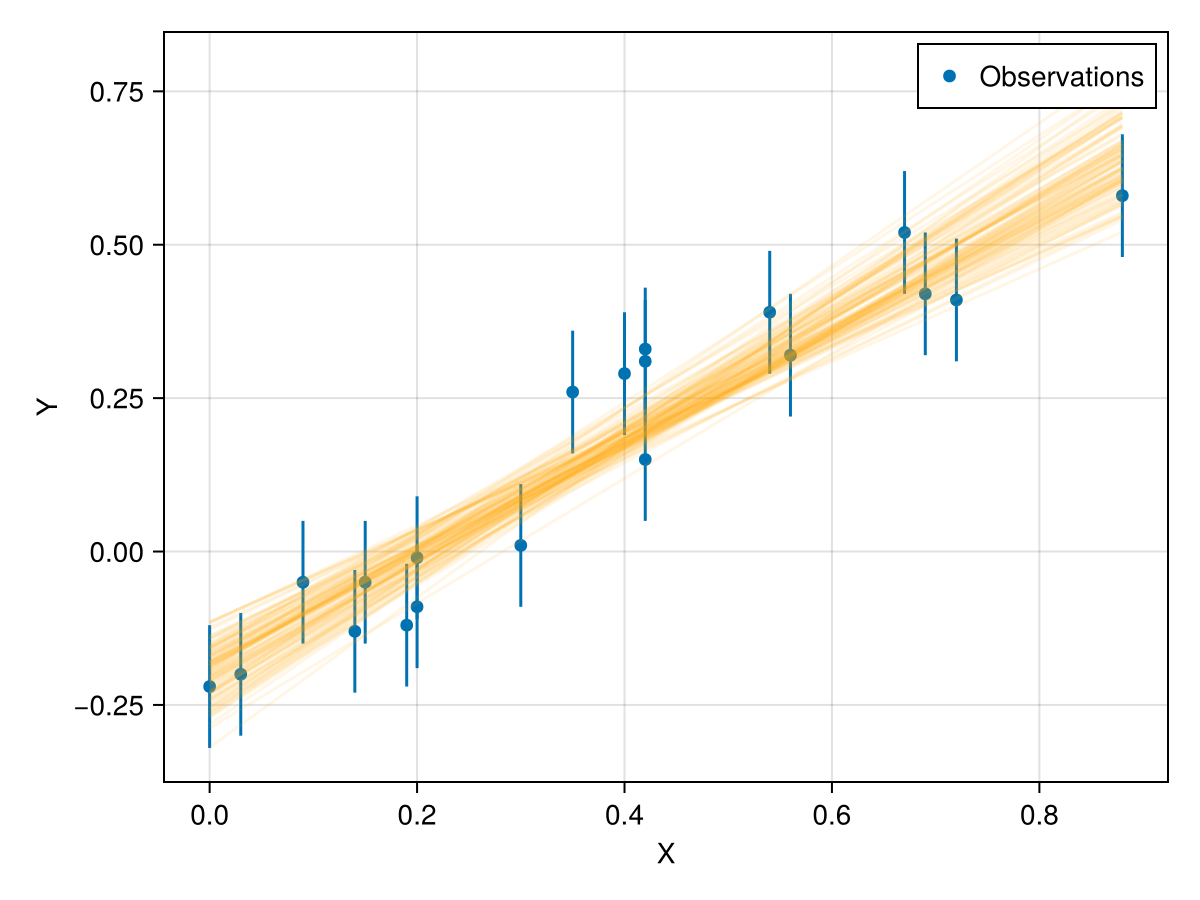

In [19]:
f = Figure()
ax = Axis(f[1, 1],
    xlabel = "X",
    ylabel = "Y"
    )
scatter!(x,y,label="Observations")
errorbars!(x,y,ey)
for i in rand(1:length(m_bay),100)
    yc = m_bay[i]*x.+q_bay[i]
    lines!(x,yc,color=:orange,alpha=0.1)
end
axislegend(ax)
f

Using the posterior let's now compute a set of model prediction, one for each posterior entry, and compute [Lucy's Bayesian p-value](https://ui.adsabs.harvard.edu/abs/2016A%26A...588A..19L/abstract). This is still based on a comparison of the residuals to those expected by the $\chi^2$ distribution. Yet, it is based on the whole posterior distribution and not only on the best-fit value.

In [20]:
model = []
for i in 1:length(m_bay)
    c = []
    for l in 1:length(x)
        push!(c,m_bay[i] * x[l] + q_bay[i])
    end
    push!(model,c)
end

In [21]:
printfmtln("Lucy's p-value = {:.4f}", Lucy_Bayesian_p_value(model,y,ey,2))

Lucy's p-value = 0.8774


This is very close to the Frequentist value, as expected after checking the posterior shape.

Finally, we can compute a Baesyan p-value following [Gelman et al.](http://www.stat.columbia.edu/~gelman/book/) Here, we no more refer to the $\chi^2$ distribution but we need to compute a set of simulated observations basing on the posterior distribution. Then, we compute the residuals of the models computed above wrt the data and the residuals of the simulated data wrt the models. So, this is a test entirely based on the posterior distribution.

In [22]:
modelS = []
for i in 1:length(m_bay)
    c = []
    for l in 1:length(x)
        d = Normal(0,ey[l])
        dr = rand(d,1)[1]
        push!(c,model[i][l] + dr)
    end
    push!(modelS,c)
end

In [23]:
printfmtln("Gelman et. al p-value = {:.4f}", Gelman_Bayesian_p_value(model,modelS,y,ey))

Gelman et. al p-value = 0.8404


A value still close but slightly different than those obtained before. More information about the Gelman et al. algorithm can be found [here](http://www.stat.columbia.edu/~gelman/research/published/ppc_understand3.pdf).